## HW3: Decision Tree, AdaBoost and Random Forest
In hw3, you need to implement decision tree, adaboost and random forest by using only numpy, then train your implemented model by the provided dataset. TA will use the on-hold test label to evaluate your model performance.

Please note that only **NUMPY** can be used to implement your model, you will get no points by simply calling `sklearn.tree.DecisionTreeClassifier`

## Question 1
Gini Index or Entropy is often used for measuring the “best” splitting of the data. Please compute the Entropy and Gini Index of provided data. Please use the formula from [page 5 of hw3 slides](https://docs.google.com/presentation/d/1kIe_-YZdemRMmr_3xDy-l0OS2EcLgDH7Uan14tlU5KE/edit#slide=id.gd542a5ff75_0_15)

In [1]:
import numpy as np
# Copy and paste your implementations right here to check your result
# (Of course you can add your classes not written here)
def class_counts(sequence):
    counts = {} # dictionary
    for item in sequence:
        label = item
        if label not in counts: # 第一次算到
            counts[label] = 0
        counts[label] += 1
    return counts

def gini(sequence):
    counts = class_counts(sequence)
    gini = 1
    for c in counts: # 跑過所有label
        prob = counts[c] / len(sequence)
        gini -= prob**2
    return gini

def entropy(sequence):
    counts = class_counts(sequence)
    entropy = 0
    for c in counts: # 跑過所有label
        prob = counts[c] / len(sequence)
        entropy -= prob * np.log2(prob)
    return entropy

In [2]:
# 1 = class 1,
# 2 = class 2
data = np.array([1,2,1,1,1,1,2,2,1,1,2])
print("Gini of data is ", gini(data))
print("Entropy of data is ", entropy(data))

Gini of data is  0.4628099173553719
Entropy of data is  0.9456603046006401


## Load data
It is a binary classifiation dataset that classify if price is high or not for a cell phone, the label is stored in `price_range` column.

In [3]:
import pandas as pd
from csv import reader

train_df = pd.read_csv('/Users/chunpei/ML/hw3/train.csv')
val_df = pd.read_csv('/Users/chunpei/ML/hw3/val.csv')
print(train_df.shape)
print(val_df.shape)
train_df.head()

(1200, 21)
(300, 21)


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,1583,1,2.1,1,11,0,14,0.7,148,7,...,942,1651,1704,17,13,2,1,0,1,1
1,745,1,0.6,1,5,0,35,0.8,102,8,...,89,1538,2459,14,1,16,1,1,0,0
2,832,0,0.7,1,2,1,39,0.7,103,4,...,125,1504,1799,5,2,11,1,0,1,0
3,1175,1,1.3,0,2,0,19,0.3,164,7,...,873,1394,1944,9,4,9,1,1,0,0
4,695,0,0.5,0,18,1,12,0.6,196,2,...,1649,1829,2855,16,13,7,1,1,1,1


## Question 2
Implement the Decision Tree algorithm (CART, Classification and Regression Trees) and trained the model by the given arguments, and print the accuracy score on the validation data. You should implement two arguments for the Decision Tree algorithm
1. **criterion**: The function to measure the quality of a split. Your model should support `gini` for the Gini impurity and `entropy` for the information gain. 
2. **max_depth**: The maximum depth of the tree. If `max_depth=None`, then nodes are expanded until all leaves are pure. `max_depth=1` equals to split data once


In [4]:
class Question: #column對應到第幾個feature，value代表分界的threshold
    def __init__(self, column, value):
        self.column = column
        self.value = value

class Leaf: #決定代表的class
    def __init__(self, data):
        content = [(value, key) for key, value in class_counts(data[:,-1]).items()]
        self.predictions = max(content)[1]

class Decision_Node: #record the question and two child nodes
    def __init__(self, question, true_branch, false_branch, len_true_branch, len_false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.len_true_branch = len_true_branch
        self.len_false_branch = len_false_branch

In [5]:
class DecisionTree():
    def __init__(self, criterion, max_depth):
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_features = -1
        self.features_counting = np.zeros(20)

    def fit(self, x_data, y_data):
        row = x_data.shape[0]
        col = x_data.shape[1] + 1 #加上lable
        data = np.empty(shape=(row, col))
        data.fill(0)
        data[:, 0:(col-1)] = x_data
        data[:, -1] = y_data #合併x_data, y_data成data
        level = 0 # root depth = 0
        self.features_counting = np.zeros(col - 1) # question3用到
        self.mytree = self.build_tree(data, level)
        
    def build_tree(self, data, level):
        gain, question = self.find_best_split(data) # 找到這一次best_split的gain跟question
        if gain == 0 or level == self.max_depth: # gain = 0 or reach max_depth，Leaf node
          return Leaf(data)
        true_rows, false_rows = self.partition(data, question) # 把資料根據question分成兩堆
        self.features_counting[question.column] += 1 # question3用到
        # print(question.column, " ", question.value, " ", len(true_rows), " ", len(false_rows))
        true_branch = self.build_tree(true_rows, level+1) # build the true branch recursively
        false_branch = self.build_tree(false_rows, level+1) # build the false branch recursively
        return Decision_Node(question, true_branch, false_branch, len(true_rows), len(false_rows))

    def find_best_split(self, data):
      best_gain = 0
      best_question = None
      if self.criterion =='gini': # 根據不同criterion call function，calculate current value
        cri_now = gini(data[:, -1])
      elif self.criterion =='entropy':
        cri_now = entropy(data[:,-1])
      
      if self.max_features != -1: # random forest case
        feature_list = np.random.choice((data.shape[1]-1), self.max_features, replace=False) # produce feature list
        feature_list = feature_list.tolist()
      
      for col in range(data.shape[1] - 1):  # for each feature column
          if self.max_features != -1: # random forest case
            if col not in feature_list: # 只做在feature_list內的
              continue
          values = set([data[i, col] for i in range(data.shape[0])]) # unique values in this feature column
          for val in values:
              question = Question(col, val)
              true_rows, false_rows = self.partition(data, question) # 把資料根據question分成兩堆，測試看看question選得好不好
              if len(true_rows) == 0 or len(false_rows) == 0: # can't divide -> skip
                  continue
              p = float(len(true_rows) / (len(true_rows) + len(false_rows)))
              if self.criterion =='gini':
                gain = cri_now - p * gini(true_rows[:, -1]) - (1 - p) * gini(false_rows[:, -1]) # calculate the information gain
              elif self.criterion =='entropy':
                gain = cri_now - p * entropy(true_rows[:, -1]) - (1 - p) * entropy(false_rows[:, -1])
              if gain > best_gain:
                  best_gain, best_question = gain, question
      return best_gain, best_question

    def partition(self, data, question):
      true_rows, false_rows = [], []
      for i in range(data.shape[0]): # 所有資料根據question做分類
          if data[i, question.column] >= question.value:
              true_rows.append(data[i, :])
          else:
              false_rows.append(data[i, :])
      true_rows = np.array(true_rows)
      false_rows = np.array(false_rows)
      return true_rows, false_rows
    
    def predict(self, data):
        if isinstance(data, pd.DataFrame): data = data.values
        predit_list = []
        for i in range(data.shape[0]):
          pred = self.classify(data, i, self.mytree) # 每筆資料的classify結果
          predit_list.append(pred)
        predit_list = np.array(predit_list)
        return predit_list

    def classify(self, data, i, node):
        if isinstance(node, Leaf): # reach a leaf
            return node.predictions
        if data[i, node.question.column] >= node.question.value:
            return self.classify(data, i, node.true_branch) # recursive直到找到結果
        else:
            return self.classify(data, i, node.false_branch)

    def accuracy(self, data):
        t = 0
        f = 0
        for i in range(data.shape[0]):
            if data[i, -1] == self.classify(data, i, self.mytree): # correct
                t += 1
            else:
                f += 1
        return t / (t + f)

### Question 2.1
Using `criterion=gini`, showing the accuracy score of validation data by `max_depth=3` and `max_depth=10`, respectively.


In [6]:
clf_depth3 = DecisionTree(criterion='gini', max_depth=3)
clf_depth3.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_depth3.accuracy(val_df.values))

clf_depth10 = DecisionTree(criterion='gini', max_depth=10)
clf_depth10.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_depth10.accuracy(val_df.values))

0.92
0.93


### Question 2.2
Using `max_depth=3`, showing the accuracy score of validation data by `criterion=gini` and `criterion=entropy`, respectively.


In [7]:
clf_gini = DecisionTree(criterion='gini', max_depth=3)
clf_gini.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_gini.accuracy(val_df.values))

clf_entropy = DecisionTree(criterion='entropy', max_depth=3)
clf_entropy.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_entropy.accuracy(val_df.values))

0.92
0.9333333333333333


- Note: Your decisition tree scores should over **0.9**. It may suffer from overfitting, if so, you can tune the hyperparameter such as `max_depth`
- Note: You should get the same results when re-building the model with the same arguments,  no need to prune the trees
- Hint: You can use the recursive method to build the nodes


## Question 3
Plot the [feature importance](https://sefiks.com/2020/04/06/feature-importance-in-decision-trees/) of your Decision Tree model. You can get the feature importance by counting the feature used for splitting data.

- You can simply plot the **counts of feature used** for building tree without normalize the importance. Take the figure below as example, outlook feature has been used for splitting for almost 50 times. Therefore, it has the largest importance

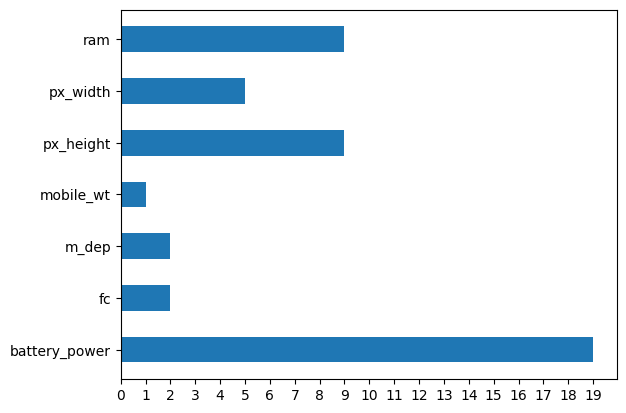

In [8]:
import matplotlib.pyplot as plt
label = ['battery_power','blue','clock_speed','dual_sim','fc','four_g','int_memory','m_dep','mobile_wt','n_cores','pc','px_height','px_width','ram','sc_h','sc_w','talk_time','three_g','touch_screen','wifi']
feature_count = []
final_label = [] # 有被用到的再印
for i in range(train_df.shape[1]-1):
    if clf_depth10.features_counting[i] != 0: # 有用到這個feature
        feature_count.append(clf_depth10.features_counting[i])
        final_label.append(label[i])
plt.barh(final_label, feature_count, tick_label=final_label, height=0.5)
x_ticks=np.arange(0,20,1)
plt.xticks(x_ticks)
plt.show()

## Question 4
implement the AdaBooest algorithm by using the CART you just implemented from question 2 as base learner. You should implement one arguments for the AdaBooest.
1. **n_estimators**: The maximum number of estimators at which boosting is terminated

In [9]:
class AdaBoost():
    def __init__(self, n_estimators):
        self.n_estimators = n_estimators
        self.dtrees = []
        self.mytrees = []
        self.criterion = 'gini'
        self.max_depth = 1

    def fit(self, x_data, y_data):
        row = x_data.shape[0]
        col = x_data.shape[1] + 1 #加上lable
        data = np.empty(shape=(row, col))
        data.fill(0)
        data[:, 0:(col-1)] = x_data
        data[:, -1] = y_data #合併x_data, y_data成data
        self.build_tree(data)

    def build_tree(self, o_data):
        w = np.full(o_data.shape[0], (1 / o_data.shape[0]))
        for _ in range(self.n_estimators): # for each classifiers
          index = np.random.choice(o_data.shape[0], o_data.shape[0], replace=True, p=w) # 根據weight隨機sample data
          index = index.tolist()
          data = np.empty(shape=(o_data.shape[0],o_data.shape[1]))
          data.fill(0)
          for i in range(o_data.shape[0]):
            data[i] = o_data[index[i]] # update data

          dtree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth) # find the best stump (using updated data)
          mytree = dtree.build_tree(data, 0)

          total_error = 0
          for i in range(o_data.shape[0]): # for each original data
            if o_data[i, -1] != dtree.classify(o_data, i, mytree): # incorrect
              total_error += w[i]
          mytree.alpha = (1/2) * (np.log((1 - total_error) / total_error)) # calculate alpha

          for i in range(o_data.shape[0]):
            if o_data[i, -1] != dtree.classify(o_data, i, mytree): # incorrect -> +alpha
              w[i] *= np.exp(mytree.alpha)
            else:
              w[i] *= np.exp(-(mytree.alpha)) # correct -> -alpha
          w /= sum(w) # normalize

          # save
          self.dtrees.append(dtree)
          self.mytrees.append(mytree)

    def predict(self, data):
        if isinstance(data, pd.DataFrame): data = data.values
        predit_list = []
        for i in range(data.shape[0]):
          result = 0
          for j in range(self.n_estimators):
            if self.dtrees[j].classify(data, i, self.mytrees[j]) == 0: # classify結果為0(相較於adaboost的-1)
              result -= self.mytrees[j].alpha
            else:
              result += self.mytrees[j].alpha
          if result > 0: # ababoost class1，相當於data的class1
            pred = 1
          else: # ababoost class-1，相當於data的class0
            pred = 0
          predit_list.append(pred)
        predit_list = np.array(predit_list)
        return predit_list

    def accuracy(self, data):
      t = 0
      f = 0
      predit_list = self.predict(data)
      for i in range(data.shape[0]):
        if predit_list[i] == data[i, -1]:
          t += 1
        else:
          f += 1
      return t / (t + f)


### Question 4.1
Show the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [10]:
clf10 = AdaBoost(n_estimators=10)
clf10.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf10.accuracy(val_df.values))

clf100 = AdaBoost(n_estimators=100)
clf100.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf100.accuracy(val_df.values))

0.9466666666666667
0.9666666666666667


## Question 5
implement the Random Forest algorithm by using the CART you just implemented from question 2. You should implement three arguments for the Random Forest.

1. **n_estimators**: The number of trees in the forest. 
2. **max_features**: The number of random select features to consider when looking for the best split
3. **bootstrap**: Whether bootstrap samples are used when building tree


In [11]:
class RandomForest():
    def __init__(self, n_estimators, max_features, boostrap=True, criterion='gini', max_depth=None):
        self.n_estimators = n_estimators
        self.max_features = int(np.around(max_features))
        self.boostrap = boostrap
        self.criterion = criterion
        self.max_depth = max_depth
        self.dtrees = []
        self.mytrees = []

    def fit(self, x_data, y_data):
        row = x_data.shape[0]
        col = x_data.shape[1] + 1 #加上lable
        data = np.empty(shape=(row, col))
        data.fill(0)
        data[:, 0:(col-1)] = x_data
        data[:, -1] = y_data #合併x_data, y_data成data
        self.build_tree(data)

    def build_tree(self, o_data):
        total_row = o_data.shape[0]
        total_col = o_data.shape[1] - 1
        for _ in range(self.n_estimators): # for each classifiers
          if self.boostrap == True:
            row_index = np.random.choice(total_row, total_row, replace=True) # 隨機sample data (uniform distributed)
            row_index = row_index.tolist()
            data = np.empty(shape=(total_row, total_col+1))
            data.fill(0)
            for i in range(total_row):
              data[i] = o_data[row_index[i]] # update data
          else:
            data = o_data
          dtree = DecisionTree(criterion=self.criterion, max_depth=self.max_depth)
          dtree.max_features = self.max_features # 設定max_features
          mytree = dtree.build_tree(data, 0)
          self.dtrees.append(dtree)
          self.mytrees.append(mytree)

    def predict(self, data):
        if isinstance(data, pd.DataFrame): data = data.values
        predit_list = []
        for i in range(data.shape[0]):
          pred0 = 0
          pred1 = 0
          for j in range(self.n_estimators):
            if self.dtrees[j].classify(data, i, self.mytrees[j]) == 0: # classify結果為0
              pred0 += 1
            else:
              pred1 +=1
          if pred0 > pred1: # majority vote
            pred = 0
          else:
            pred = 1
          predit_list.append(pred)
        predit_list = np.array(predit_list)
        return predit_list

    def accuracy(self, data):
      t = 0
      f = 0
      predit_list = self.predict(data)
      for i in range(data.shape[0]):
        if predit_list[i] == data[i, -1]:
          t += 1
        else:
          f += 1
      return t / (t + f)

### Question 5.1
Using `criterion=gini`, `max_depth=None`, `max_features=sqrt(n_features)`, showing the accuracy score of validation data by `n_estimators=10` and `n_estimators=100`, respectively.


In [12]:
clf_10tree = RandomForest(n_estimators=10, max_features=np.sqrt(train_df.values.shape[1]-1))
clf_10tree.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_10tree.accuracy(val_df.values))

clf_100tree = RandomForest(n_estimators=100, max_features=np.sqrt(train_df.values.shape[1]-1))
clf_100tree.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_100tree.accuracy(val_df.values))

0.9466666666666667
0.9466666666666667


### Question 5.2
Using `criterion=gini`, `max_depth=None`, `n_estimators=10`, showing the accuracy score of validation data by `max_features=sqrt(n_features)` and `max_features=n_features`, respectively.


In [13]:
clf_random_features = RandomForest(n_estimators=10, max_features=np.sqrt(train_df.values.shape[1]-1))
clf_random_features.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_random_features.accuracy(val_df.values))

clf_all_features = RandomForest(n_estimators=10, max_features=(train_df.values.shape[1]-1))
clf_all_features.fit(train_df.values[:, 0:(train_df.shape[1]-1)], train_df.values[:, -1])
print(clf_all_features.accuracy(val_df.values))

0.9566666666666667
0.96


- Note: Use majority votes to get the final prediction, you may get slightly different results when re-building the random forest model

## Question 6. Train and tune your model on a real-world dataset
Try you best to get higher accuracy score of your model. After parameter tuning, you can train your model on the full dataset (train + val).
- Feature engineering
- Hyperparameter tuning
- Implement any other ensemble methods, such as gradient boosting. Please note that you **can not** call any package. Also, only ensemble method can be used. Neural network method is not allowed to used.

In [14]:
def train_your_model(data):
    model = AdaBoost(n_estimators=100)
    model.criterion = 'gini'
    model.max_depth = 1
    model.fit(data.values[:, 0:(data.shape[1]-1)], data.values[:, -1])
    return model

In [25]:
import pickle
import pandas as pd
import numpy as np

train_df = pd.read_csv('/Users/chunpei/ML/hw3/train.csv')
val_df = pd.read_csv('/Users/chunpei/ML/hw3/val.csv')
trainval_df = pd.concat([train_df, val_df])
my_model = train_your_model(trainval_df)

In [20]:
x_test = pd.read_csv('/Users/chunpei/ML/hw3/x_test.csv')
y_pred = my_model.predict(x_test)


with open('model.pickle', 'wb') as pkl_file:
    pickle.dump(my_model, pkl_file, protocol=pickle.HIGHEST_PROTOCOL)

np.save("y_pred.npy", y_pred)

In [21]:
assert y_pred.shape == (500, )

## Supplementary
If you have trouble to implement this homework, TA strongly recommend watching [this video](https://www.youtube.com/watch?v=LDRbO9a6XPU), which explains Decision Tree model clearly. But don't copy code from any resources, try to finish this homework by yourself! 

### DO NOT MODIFY CODE BELOW

In [17]:
import pandas as pd
from sklearn.metrics import accuracy_score

In [ ]:
y_test = pd.read_csv('y_test.csv')['price_range'].values

print('Test-set accuarcy score: ', accuracy_score(y_test, y_pred))

In [18]:
def discrete_checker(score, thres, clf, name, x_train, y_train, x_test, y_test):
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    if accuracy_score(y_test, y_pred) - thres >= 0:
        return score
    else:
        print(f"{name} failed")
        return 0


def patient_checker(score, thres, CLS, kwargs, name,
                    x_train, y_train, x_test, y_test, patient=10):
    while patient > 0:
        patient -= 1
        clf = CLS(**kwargs)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        if accuracy_score(y_test, y_pred) - thres >= 0:
            return score
    print(f"{name} failed")
    print("Considering the randomness, we will check it manually")
    return 0


def load_dataset():
    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv"
    df = pd.read_csv(
        file_url,
        names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
               "Viscera weight", "Shell weight", "Age"]
    )

    df['Target'] = (df["Age"] > 15).astype(int)
    df = df.drop(labels=["Age"], axis="columns")

    train_idx = range(0, len(df), 10)
    test_idx = range(1, len(df), 20)

    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]

    x_train = train_df.drop(labels=["Target"], axis="columns")
    feature_names = x_train.columns.values
    x_train = x_train.values
    y_train = train_df['Target'].values

    x_test = test_df.drop(labels=["Target"], axis="columns")
    x_test = x_test.values
    y_test = test_df['Target'].values
    return x_train, y_train, x_test, y_test, feature_names


score = 0

data = np.array([1, 2])
if abs(gini(data) - 0.5) < 1e-4:
    score += 2.5
else:
    print("gini test failed")

if abs(entropy(data) - 1) < 1e-4:
    score += 2.5
else:
    print("entropy test failed")

x_train, y_train, x_test, y_test, feature_names = load_dataset()

score += discrete_checker(5, 0.9337,
                          DecisionTree(criterion='gini', max_depth=3),
                          "DecisionTree(criterion='gini', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9036,
                          DecisionTree(criterion='gini', max_depth=10),
                          "DecisionTree(criterion='gini', max_depth=10)",
                          x_train, y_train, x_test, y_test
                          )

score += discrete_checker(2.5, 0.9096,
                          DecisionTree(criterion='entropy', max_depth=3),
                          "DecisionTree(criterion='entropy', max_depth=3)",
                          x_train, y_train, x_test, y_test
                          )

print("*** We will check your result for Question 3 manually *** (5 points)")

score += patient_checker(
    7.5, 0.91, AdaBoost, {"n_estimators": 10},
    "AdaBoost(n_estimators=10)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    7.5, 0.87, AdaBoost, {"n_estimators": 100},
    "AdaBoost(n_estimators=100)",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 10, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=10, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.91, RandomForest,
    {"n_estimators": 100, "max_features": np.sqrt(x_train.shape[1])},
    "RandomForest(n_estimators=100, max_features=sqrt(n_features))",
    x_train, y_train, x_test, y_test
)

score += patient_checker(
    5, 0.92, RandomForest,
    {"n_estimators": 10, "max_features": x_train.shape[1]},
    "RandomForest(n_estimators=10, max_features=n_features)",
    x_train, y_train, x_test, y_test
)

print("*** We will check your result for Question 6 manually *** (20 points)")
print("Approximate score range:", score, "~", score + 25)
print("*** This score is only for reference ***")

*** We will check your result for Question 3 manually *** (5 points)
*** We will check your result for Question 6 manually *** (20 points)
Approximate score range: 45.0 ~ 70.0
*** This score is only for reference ***
